# PTB-XL: Comprehensive, Logical EDA

This notebook presents a structured, environment-friendly exploratory analysis of the PTB-XL dataset:

1. Setup and configuration
2. Load metadata and define label taxonomy
3. Basic dataset overview (records, patients, demographics)
4. Label parsing and distributions
5. Multi-label metrics (cardinality/density)
6. Co-occurrence heatmaps (superclasses and top SCP codes)
7. Devices, sites, and noise flags
8. Correlations of numeric features and distributions
9. Demographic prevalence (sex, age bands)
10. Temporal trends (counts and label prevalence by year)
11. Official stratified split summary
12. Waveform example (100 Hz)

All plots use plain Matplotlib to maximize compatibility. Update DATA_ROOT if needed.


In [1]:
# 1) Setup and configuration
import os
import ast
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import wfdb
except Exception:
    wfdb = None
    warnings.warn("wfdb not installed; waveform example will be skipped.")

# Minimal style fallback for older Matplotlib/Seaborn versions
for style_name in ['seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'seaborn']:
    try:
        plt.style.use(style_name)
        break
    except Exception:
        continue

DATA_ROOT = os.path.abspath("data/ptb-xl/")
DB_CSV = os.path.join(DATA_ROOT, "ptbxl_database.csv")
SCP_CSV = os.path.join(DATA_ROOT, "scp_statements.csv")

assert os.path.exists(DB_CSV), f"Missing {DB_CSV}"
assert os.path.exists(SCP_CSV), f"Missing {SCP_CSV}"

print("Using DATA_ROOT:", DATA_ROOT)


/home/yasser.eljarida/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using DATA_ROOT: /srv/lustre01/project/recsys-y8xnv0gztug/users/yasser.eljarida/code/ecg/data/ptb-xl


In [2]:
# 2) Load metadata and define label taxonomy
ptbxl_df = pd.read_csv(DB_CSV)
scp_df = pd.read_csv(SCP_CSV, index_col=0)

# Parse SCP codes dict
ptbxl_df['scp_codes_dict'] = ptbxl_df['scp_codes'].apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else {})

# Build diagnostic label map from scp_statements
scp_diag = scp_df[scp_df['diagnostic'] == 1]
label_map = scp_diag['diagnostic_class'].to_dict()  # SCP code -> superclass

# Derive diagnostic superclasses per record
ptbxl_df['diagnostic_superclass'] = ptbxl_df['scp_codes_dict'].apply(
    lambda d: sorted({label_map[c] for c in d.keys() if c in label_map})
)

# Keep primary SCP (highest confidence) for quick summaries
ptbxl_df['primary_scp'] = ptbxl_df['scp_codes_dict'].apply(lambda d: max(d.items(), key=lambda kv: kv[1])[0] if d else None)

superclasses = sorted({c for classes in ptbxl_df['diagnostic_superclass'] for c in classes})
print('Superclasses:', superclasses)
ptbxl_df.head(3)


Superclasses: ['CD', 'HYP', 'MI', 'NORM', 'STTC']


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,scp_codes_dict,diagnostic_superclass,primary_scp
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",[NORM],NORM
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,"{'NORM': 80.0, 'SBRAD': 0.0}",[NORM],NORM
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,"{'NORM': 100.0, 'SR': 0.0}",[NORM],NORM


Records: 21799
Unique patients: 18869


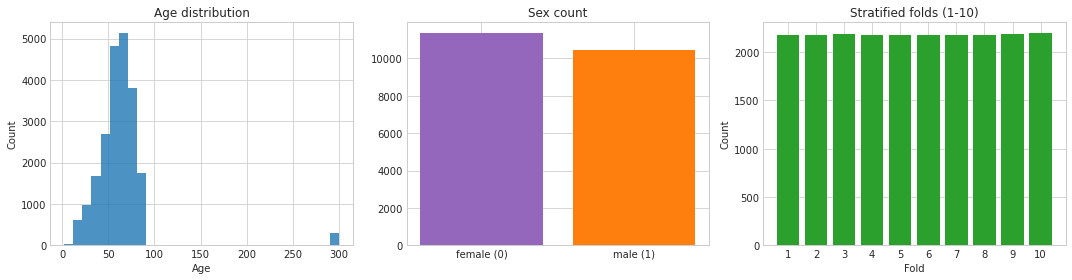

In [3]:
# 3) Basic dataset overview
n_records = len(ptbxl_df)
n_patients = ptbxl_df['patient_id'].nunique()

print(f"Records: {n_records}")
print(f"Unique patients: {n_patients}")

# Numeric demographics
ptbxl_df['age'] = pd.to_numeric(ptbxl_df['age'], errors='coerce')
ptbxl_df['sex'] = pd.to_numeric(ptbxl_df['sex'], errors='coerce')  # 0=female,1=male

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(ptbxl_df['age'].dropna(), bins=30, color='tab:blue', alpha=0.8)
axes[0].set_title('Age distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

sex_counts = ptbxl_df['sex'].value_counts().sort_index()
axes[1].bar(['female (0)','male (1)'], sex_counts.values, color=['tab:purple','tab:orange'])
axes[1].set_title('Sex count')

fold_counts = ptbxl_df['strat_fold'].value_counts().sort_index()
axes[2].bar(fold_counts.index.astype(str), fold_counts.values, color='tab:green')
axes[2].set_title('Stratified folds (1-10)')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Count')
plt.tight_layout()
plt.show()


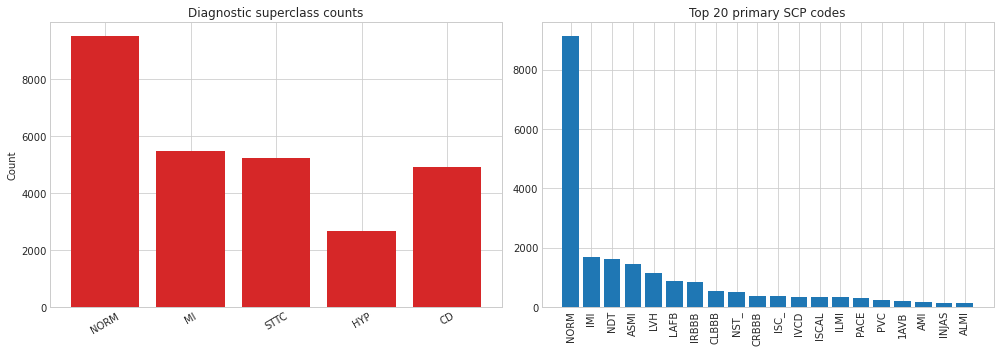

,NORM,MI,STTC,CD,HYP
count,9514,5469,5235,4898,2649


In [4]:
# 4) Label distributions
from collections import Counter

def flatten(list_of_lists):
    for sub in list_of_lists:
        for x in sub:
            yield x

superclass_counts = Counter(flatten(ptbxl_df['diagnostic_superclass']))
scp_counts = ptbxl_df['primary_scp'].value_counts().head(20)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(list(superclass_counts.keys()), list(superclass_counts.values()), color='tab:red')
axes[0].set_title('Diagnostic superclass counts')
axes[0].tick_params(axis='x', rotation=30)
axes[0].set_ylabel('Count')

axes[1].bar(scp_counts.index, scp_counts.values, color='tab:blue')
axes[1].set_title('Top 20 primary SCP codes')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

pd.DataFrame.from_dict(superclass_counts, orient='index', columns=['count']).sort_values('count', ascending=False).T


In [5]:
# 5) Multi-label metrics (cardinality, density)
# Superclasses
num_labels_super = len(superclasses)
label_cardinality_super = ptbxl_df['diagnostic_superclass'].apply(len).mean()
label_density_super = label_cardinality_super / max(num_labels_super, 1)
print(f"Superclasses: {num_labels_super}")
print(f"Label cardinality (superclasses): {label_cardinality_super:.3f}")
print(f"Label density (superclasses): {label_density_super:.3f}")

# SCP space: multi-hot for frequent codes
min_count = 100
scp_freq = ptbxl_df['primary_scp'].value_counts()
scp_keep = scp_freq[scp_freq >= min_count].index.tolist()

def scp_row_to_multihot(code_dict, keep):
    row = [0]*len(keep)
    for i, c in enumerate(keep):
        if c in code_dict:
            row[i] = 1
    return row

scp_multihot = np.vstack([
    scp_row_to_multihot(d, scp_keep) for d in ptbxl_df['scp_codes_dict']
])

label_cardinality_scp = scp_multihot.sum(axis=1).mean()
label_density_scp = label_cardinality_scp / max(len(scp_keep), 1)
print(f"SCP kept (min_count>={min_count}): {len(scp_keep)}")
print(f"Label cardinality (SCP@{min_count}+): {label_cardinality_scp:.3f}")
print(f"Label density (SCP@{min_count}+): {label_density_scp:.3f}")


Superclasses: 5
Label cardinality (superclasses): 1.274
Label density (superclasses): 0.255
SCP kept (min_count>=100): 22
Label cardinality (SCP@100+): 1.365
Label density (SCP@100+): 0.062


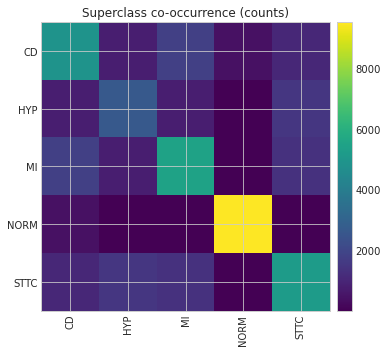

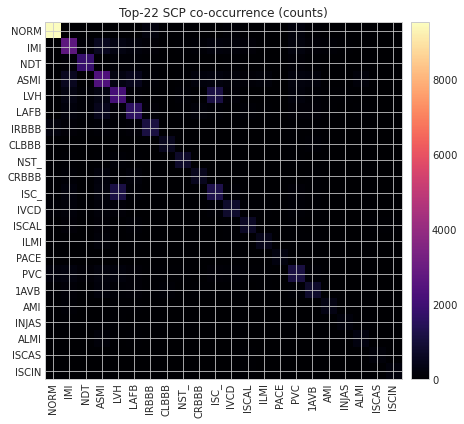

In [6]:
# 6) Co-occurrence heatmaps
from itertools import combinations

# Superclass co-occurrence
super_to_idx = {c: i for i, c in enumerate(superclasses)}
S = np.zeros((len(superclasses), len(superclasses)), dtype=int)
for classes in ptbxl_df['diagnostic_superclass']:
    idxs = [super_to_idx[c] for c in classes]
    for i in idxs:
        S[i, i] += 1
    for a, b in combinations(idxs, 2):
        S[a, b] += 1
        S[b, a] += 1

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(S, cmap='viridis')
ax.set_xticks(range(len(superclasses)))
ax.set_yticks(range(len(superclasses)))
ax.set_xticklabels(superclasses, rotation=90)
ax.set_yticklabels(superclasses)
ax.set_title('Superclass co-occurrence (counts)')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.02)
plt.tight_layout()
plt.show()

# Top-K SCP code co-occurrence
K = min(30, len(scp_keep))
X = scp_multihot[:, :K]
C = X.T @ X

fig, ax = plt.subplots(figsize=(7, 6))
cax = ax.imshow(C, cmap='magma')
ax.set_xticks(range(K))
ax.set_yticks(range(K))
ax.set_xticklabels(scp_keep[:K], rotation=90)
ax.set_yticklabels(scp_keep[:K])
ax.set_title(f'Top-{K} SCP co-occurrence (counts)')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.02)
plt.tight_layout()
plt.show()


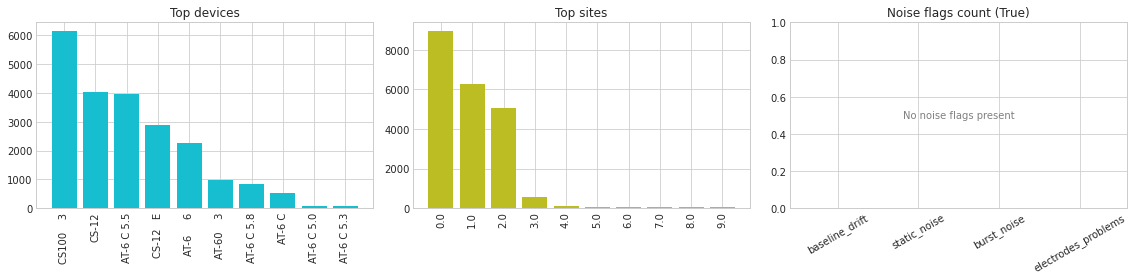

In [7]:
# 7) Devices, sites, and noise flags
# Devices and sites
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

device_counts = ptbxl_df['device'].value_counts().head(10)
axes[0].bar(range(len(device_counts)), device_counts.values, color='tab:cyan')
axes[0].set_xticks(range(len(device_counts)))
axes[0].set_xticklabels(device_counts.index.astype(str), rotation=90)
axes[0].set_title('Top devices')

site_counts = ptbxl_df['site'].value_counts().head(10)
axes[1].bar(range(len(site_counts)), site_counts.values, color='tab:olive')
axes[1].set_xticks(range(len(site_counts)))
axes[1].set_xticklabels(site_counts.index.astype(str), rotation=90)
axes[1].set_title('Top sites')

# Noise flags -> robust binary coercion
noise_cols = ['baseline_drift','static_noise','burst_noise','electrodes_problems']

def to_binary(x):
    if pd.isna(x):
        return 0
    if isinstance(x, (bool, np.bool_)):
        return int(x)
    if isinstance(x, (int, np.integer, float, np.floating)):
        return int(x != 0)
    if isinstance(x, str):
        s = x.strip().lower()
        if s in {'1','true','t','yes','y'}:
            return 1
        if s in {'0','false','f','no','n',''}:
            return 0
    return 0

noise_df = ptbxl_df[noise_cols].applymap(to_binary)
noise_counts = noise_df.sum()
axes[2].bar(range(len(noise_counts)), noise_counts.values, color='tab:gray')
axes[2].set_xticks(range(len(noise_counts)))
axes[2].set_xticklabels(noise_counts.index, rotation=30)
axes[2].set_title('Noise flags count (True)')
if int(noise_counts.sum()) == 0:
    axes[2].set_ylim(0, 1)
    axes[2].text(0.5, 0.5, 'No noise flags present', transform=axes[2].transAxes,
                 ha='center', va='center', color='gray')

plt.tight_layout()
plt.show()


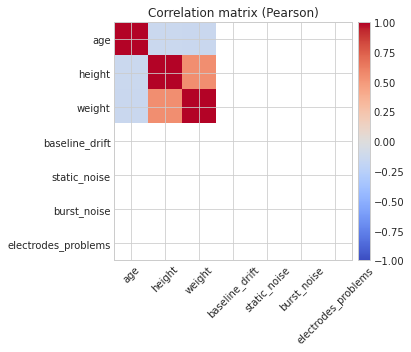

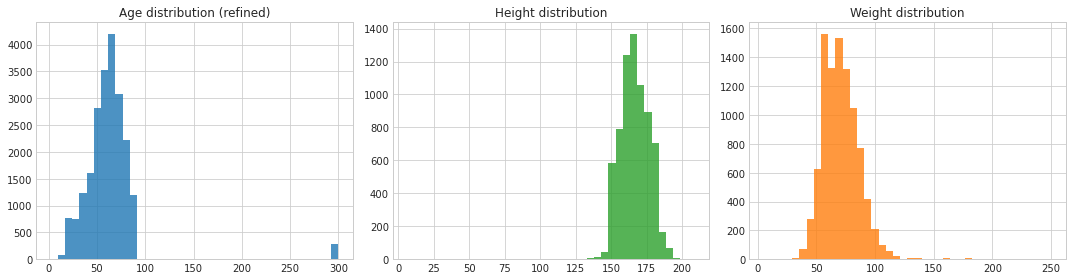

In [8]:
# 8) Correlations of numeric features and distributions
num_cols = ['age','height','weight','baseline_drift','static_noise','burst_noise','electrodes_problems']
for c in num_cols:
    if c in ptbxl_df.columns:
        ptbxl_df[c] = pd.to_numeric(ptbxl_df[c], errors='coerce')

available = [c for c in num_cols if c in ptbxl_df.columns]
cmat = ptbxl_df[available].corr()

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(cmat.values, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(available)))
ax.set_yticks(range(len(available)))
ax.set_xticklabels(available, rotation=45)
ax.set_yticklabels(available)
ax.set_title('Correlation matrix (Pearson)')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
if 'age' in ptbxl_df:
    axes[0].hist(ptbxl_df['age'].dropna(), bins=40, color='tab:blue', alpha=0.8)
    axes[0].set_title('Age distribution (refined)')
if 'height' in ptbxl_df:
    axes[1].hist(ptbxl_df['height'].dropna(), bins=40, color='tab:green', alpha=0.8)
    axes[1].set_title('Height distribution')
if 'weight' in ptbxl_df:
    axes[2].hist(ptbxl_df['weight'].dropna(), bins=40, color='tab:orange', alpha=0.8)
    axes[2].set_title('Weight distribution')
plt.tight_layout()
plt.show()


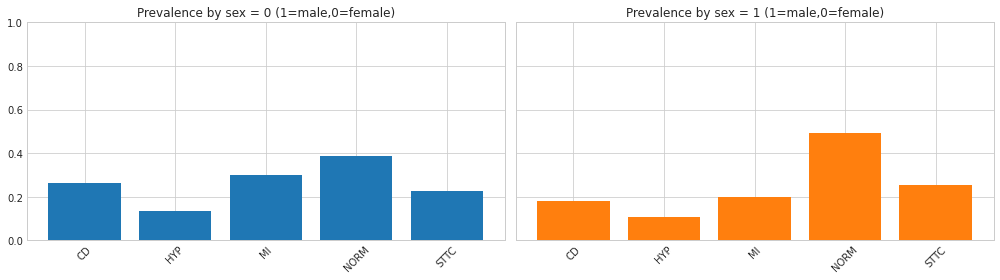

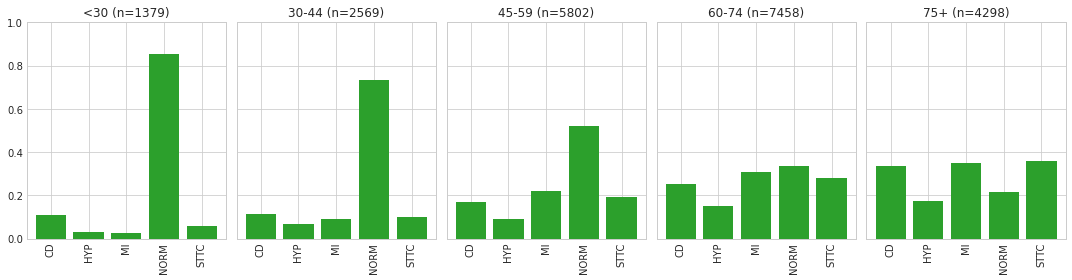

In [9]:
# 9) Demographic prevalence (sex, age bands)
age_bins = [0, 30, 45, 60, 75, 200]
age_labels = ['<30','30-44','45-59','60-74','75+']
ptbxl_df['age_band'] = pd.cut(ptbxl_df['age'], bins=age_bins, labels=age_labels, right=False)

# Multi-hot per superclass
super_to_idx = {c: i for i, c in enumerate(superclasses)}
Y_super = np.zeros((len(ptbxl_df), len(superclasses)), dtype=int)
for i, classes in enumerate(ptbxl_df['diagnostic_superclass']):
    for c in classes:
        Y_super[i, super_to_idx[c]] = 1

# Sex-wise prevalence
sex_groups = ptbxl_df.groupby('sex').groups
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
for ax_idx, (sex_val, idxs) in enumerate(sex_groups.items()):
    if np.isnan(sex_val):
        continue
    m = Y_super[list(idxs)].mean(axis=0)
    axes[ax_idx].bar(range(len(superclasses)), m, color='tab:blue' if sex_val==0 else 'tab:orange')
    axes[ax_idx].set_xticks(range(len(superclasses)))
    axes[ax_idx].set_xticklabels(superclasses, rotation=45)
    axes[ax_idx].set_ylim(0, 1)
    axes[ax_idx].set_title(f"Prevalence by sex = {int(sex_val)} (1=male,0=female)")
plt.tight_layout()
plt.show()

# Age-band prevalence
age_groups = ptbxl_df.groupby('age_band').groups
fig, axes = plt.subplots(1, len(age_labels), figsize=(3*len(age_labels), 4), sharey=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
for i, label in enumerate(age_labels):
    idxs = age_groups.get(label, [])
    if len(idxs) == 0:
        axes[i].set_title(f"{label}\n(n=0)")
        axes[i].set_xticks([])
        continue
    m = Y_super[list(idxs)].mean(axis=0)
    axes[i].bar(range(len(superclasses)), m, color='tab:green')
    axes[i].set_xticks(range(len(superclasses)))
    axes[i].set_xticklabels(superclasses, rotation=90)
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f"{label} (n={len(idxs)})")
plt.tight_layout()
plt.show()


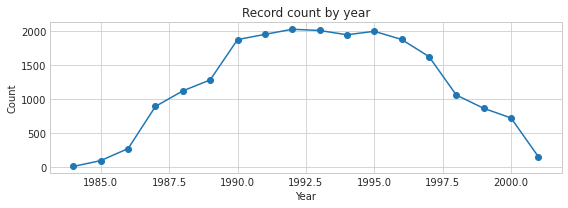

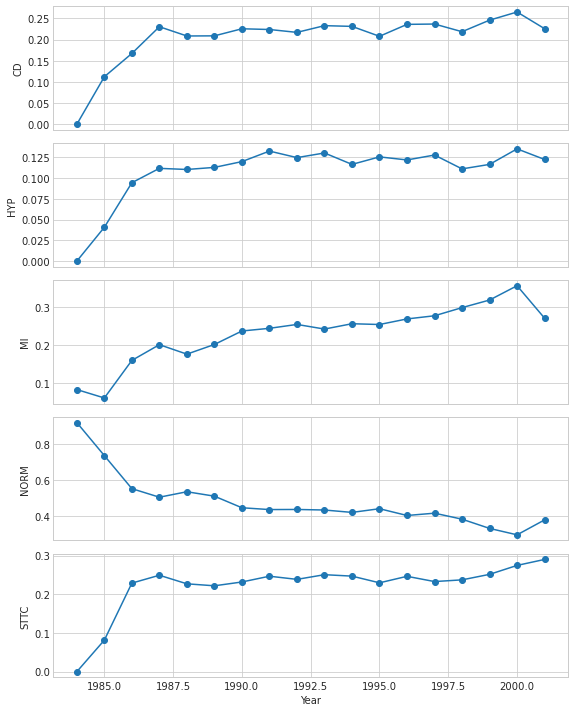

In [10]:
# 10) Temporal trends
ptbxl_df['recording_date'] = pd.to_datetime(ptbxl_df['recording_date'], errors='coerce')
ptbxl_df['year'] = ptbxl_df['recording_date'].dt.year

counts_by_year = ptbxl_df.groupby('year').size().sort_index()

fig, ax = plt.subplots(figsize=(8, 3))
x = counts_by_year.index.to_numpy()
y = counts_by_year.values.astype(float)
ax.plot(x, y, marker='o', color='tab:blue')
ax.set_title('Record count by year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Label prevalence by year (superclasses)
Y_super_df = pd.DataFrame(Y_super, columns=superclasses)
Y_super_df['year'] = ptbxl_df['year'].values
fig, axes = plt.subplots(len(superclasses), 1, figsize=(8, 2*len(superclasses)), sharex=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
for i, c in enumerate(superclasses):
    series = Y_super_df.groupby('year')[c].mean().sort_index()
    xi = series.index.to_numpy()
    yi = series.values.astype(float)
    axes[i].plot(xi, yi, marker='o')
    axes[i].set_ylabel(c)
axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()


In [11]:
# 11) Official stratified split summary (fold 10 test)
TEST_FOLD = 10
train_mask = ptbxl_df['strat_fold'] != TEST_FOLD
test_mask = ptbxl_df['strat_fold'] == TEST_FOLD

train_df = ptbxl_df[train_mask]
test_df = ptbxl_df[test_mask]
print('Train size:', len(train_df), 'Test size:', len(test_df))

from collections import Counter

def flatten(list_of_lists):
    for sub in list_of_lists:
        for x in sub:
            yield x

train_super = Counter(flatten(train_df['diagnostic_superclass']))
test_super = Counter(flatten(test_df['diagnostic_superclass']))

balance_df = (
    pd.DataFrame({'train': train_super, 'test': test_super})
      .fillna(0)
      .astype(int)
      .sort_index()
)
print(balance_df)


Train size: 19601 Test size: 2198
      train  test
CD     4402   496
HYP    2387   262
MI     4919   550
NORM   8551   963
STTC   4714   521


Signal shape: (1000, 12)


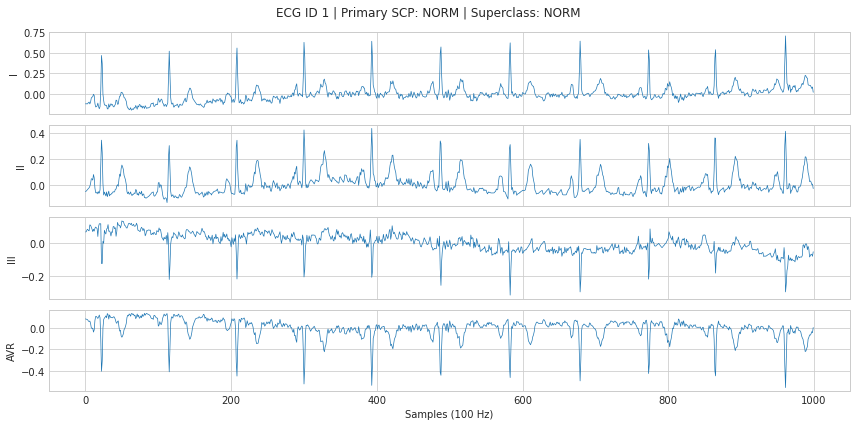

In [12]:
# 12) Waveform example (100 Hz)
if wfdb is None:
    print("wfdb not installed; skipping waveform visualization.")
else:
    try:
        sample_row = ptbxl_df.iloc[0]
        rec_path = os.path.join(DATA_ROOT, sample_row['filename_lr'])
        signal, meta = wfdb.rdsamp(rec_path)
        print('Signal shape:', signal.shape)
        lead_names = meta.get('sig_name', [f'lead_{i}' for i in range(signal.shape[1])])
        n_to_plot = min(4, signal.shape[1])
        t = np.arange(signal.shape[0])
        fig, axes = plt.subplots(n_to_plot, 1, figsize=(12, 6), sharex=True)
        if n_to_plot == 1:
            axes = [axes]
        for i in range(n_to_plot):
            axes[i].plot(t, signal[:, i], lw=0.7)
            axes[i].set_ylabel(lead_names[i] if i < len(lead_names) else f'lead_{i}')
        axes[-1].set_xlabel('Samples (100 Hz)')
        fig.suptitle(f"ECG ID {int(sample_row['ecg_id'])} | Primary SCP: {sample_row['primary_scp']} | Superclass: {','.join(sample_row['diagnostic_superclass'])}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        warnings.warn(f"Failed to read waveform: {e}")
